In [1]:
import numpy as np
import pandas as pd
import sys
from pathlib import Path
from loguru import logger
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))

In [2]:
from models.cluster import KMeansClusterModel, DBSCANClusterModel, HierarchicalClusterModel
from utils.load import load_ctms_dataset
from utils.pitch import plot_clusters

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
df = load_ctms_dataset('../data/videogame_sequences/sequence_dataset.parquet')

In [ ]:
df['ctm_array'] = df['ctm'].apply(np.array)
df_hier = df.iloc[::10]
X = np.stack(df['ctm_array'].apply(lambda m: m.flatten()).to_numpy())
X_hier = np.stack(df_hier['ctm_array'].apply(lambda m: m.flatten()).to_numpy())

In [5]:
def apply_pca(X, keep_variance = 0.95):
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    pca = PCA(n_components=keep_variance, random_state=42)
    X_pca = pca.fit_transform(X_std)

    logger.info(
        f"PCA reduced from {X.shape[1]} → {X_pca.shape[1]} dims "
        f"({pca.explained_variance_ratio_.sum():.2%} variance kept)"
    )
    return X_pca

X_pca = apply_pca(X, keep_variance=0.95)
X_pca_hier = apply_pca(X_hier, keep_variance=0.8)

2025-12-01 11:33:38.042 | INFO     | __main__:apply_pca:8 - PCA reduced from 16641 → 1242 dims (95.01% variance kept)
2025-12-01 11:33:38.652 | INFO     | __main__:apply_pca:8 - PCA reduced from 16641 → 115 dims (80.22% variance kept)


In [6]:
df.to_csv('note_based_clustering.csv')
load_df = pd.read_csv('note_based_clustering.csv')

# kmeans clustering
- first determining the amount of clusters from silhouette score 

In [7]:
K_range = range(2, 11) 
silhouette_scores = []
best_score = -1
best_K = -1

for K in K_range:
    kmeans = KMeansClusterModel(n_clusters=K, random_state=42)
    kmeans.fit(X_pca)
    
    labels = kmeans.labels_
    if len(np.unique(labels)) < K:
        score = -1.0 
    else:
        score = silhouette_score(X_pca, labels)
    
    silhouette_scores.append(score)
    print(f"K={K}: Average Silhouette Score = {score:.4f}")

    if score > best_score:
        best_score = score
        best_K = K

K=2: Average Silhouette Score = 0.4833
K=3: Average Silhouette Score = 0.4248
K=4: Average Silhouette Score = 0.3342
K=5: Average Silhouette Score = 0.0552
K=6: Average Silhouette Score = 0.0494
K=7: Average Silhouette Score = 0.4696
K=8: Average Silhouette Score = 0.0147
K=9: Average Silhouette Score = 0.3272
K=10: Average Silhouette Score = 0.3128


2025-12-01 11:33:47.959 | INFO     | __main__:<module>:5 - cluster_label_kmeans
1    3316
0       4
Name: count, dtype: int64


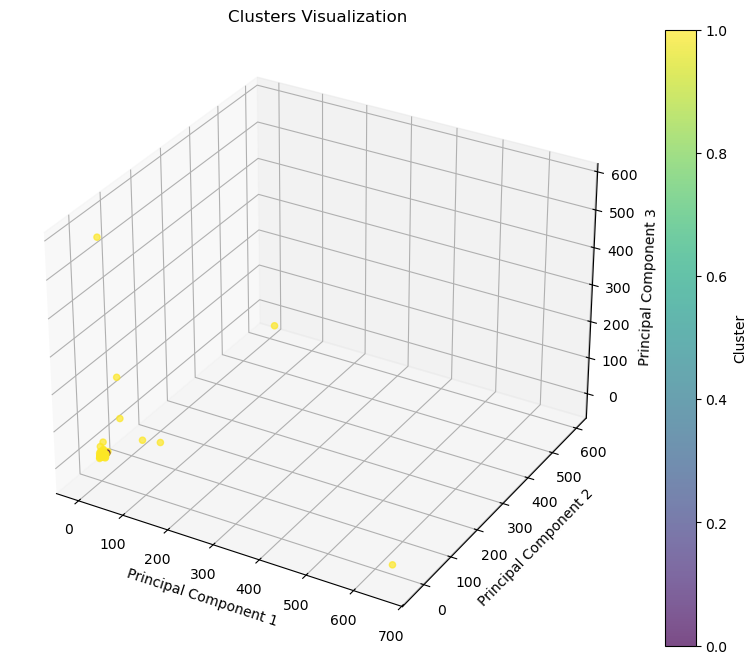

In [8]:
K = best_K
kmeans = KMeansClusterModel(n_clusters=K, random_state=42)
kmeans.fit(X_pca)
df['cluster_label_kmeans'] = kmeans.labels_
logger.info(df["cluster_label_kmeans"].value_counts())
plot_clusters(X_pca, kmeans.labels_, dim=3)

# dbscan clustering
- determining best min_samples and eps from K-Distance Graph

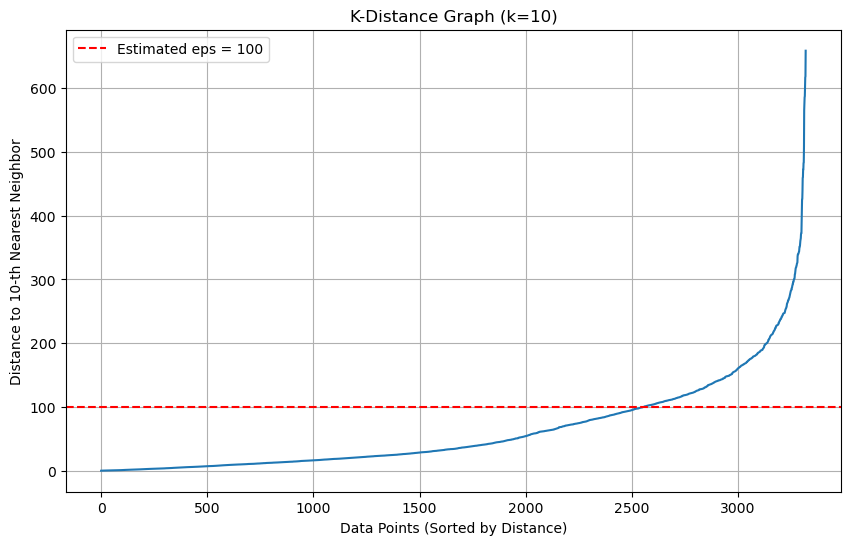

In [9]:
MIN_SAMPLES = 10
k = MIN_SAMPLES - 1

nn = NearestNeighbors(n_neighbors=MIN_SAMPLES)
nn.fit(X_pca)

distances, indices = nn.kneighbors(X_pca)
k_distances = distances[:, k]
k_distances.sort()
plt.figure(figsize=(10, 6))
plt.plot(range(len(k_distances)), k_distances)

estimated_eps = 100
plt.axhline(y=estimated_eps, color='r', linestyle='--', label=f'Estimated eps = {estimated_eps}')

plt.title(f'K-Distance Graph (k={MIN_SAMPLES})')
plt.xlabel('Data Points (Sorted by Distance)')
plt.ylabel(f'Distance to {MIN_SAMPLES}-th Nearest Neighbor')
plt.legend()
plt.grid(True)
plt.show()

min samples around 10 as dataset is noisy and eps around 75

2025-12-01 11:34:09.179 | INFO     | __main__:<module>:5 - cluster_label_dbmeans
 0    2309
-1    1011
Name: count, dtype: int64


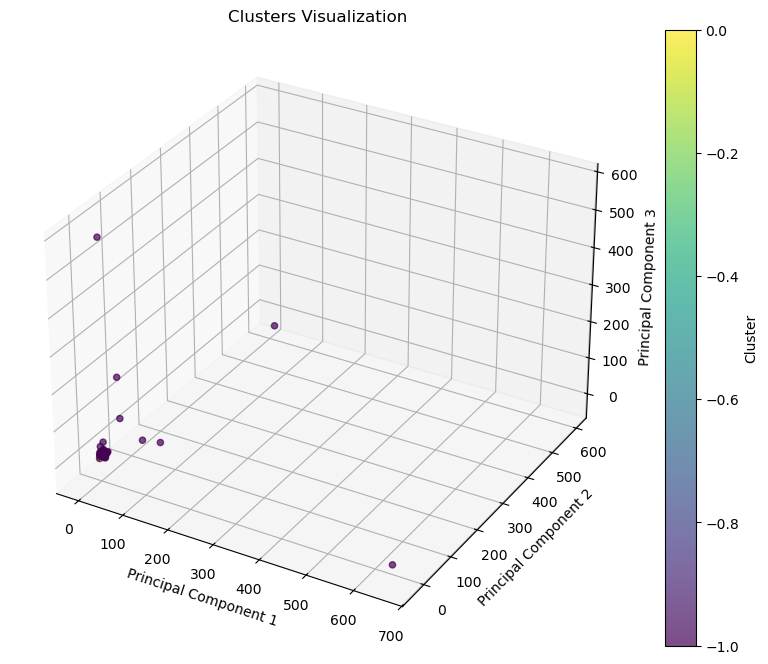

In [10]:
dbscan = DBSCANClusterModel(min_samples=10, eps=75)
dbscan.fit(X_pca)
df['cluster_label_dbmeans'] = dbscan.labels_

logger.info(df["cluster_label_dbmeans"].value_counts())
plot_clusters(X_pca, dbscan.labels_, dim=3)

# hiearichal clustering

- determining n_clusters from silhouette score

In [15]:
Z = linkage(X_pca_hier, method='ward')

for k in range(2, 15):
    model = HierarchicalClusterModel(k, method='agglomerative')
    model.fit(Z)
    labels = model.labels_
    score = silhouette_score(Z, labels)
    print(k, score)

Agglomerative Clustering: 100%|██████████| 329/329 [00:53<00:00,  6.15it/s]


2 0.38340396563771


Agglomerative Clustering: 100%|██████████| 328/328 [00:53<00:00,  6.12it/s]


3 0.4322555654160937


Agglomerative Clustering: 100%|██████████| 327/327 [00:53<00:00,  6.12it/s]


4 0.41109249937591896


Agglomerative Clustering: 100%|██████████| 326/326 [00:53<00:00,  6.09it/s]


5 0.42087935581151686


Agglomerative Clustering: 100%|██████████| 325/325 [00:53<00:00,  6.06it/s]


6 0.4193663237870698


Agglomerative Clustering: 100%|██████████| 324/324 [00:53<00:00,  6.03it/s]


7 0.36839545064146445


Agglomerative Clustering: 100%|██████████| 323/323 [00:53<00:00,  5.99it/s]


8 0.3664465595881481


Agglomerative Clustering: 100%|██████████| 322/322 [00:53<00:00,  6.02it/s]


9 0.33834431904385487


Agglomerative Clustering: 100%|██████████| 321/321 [00:53<00:00,  5.95it/s]


10 0.35422634996628977


Agglomerative Clustering: 100%|██████████| 320/320 [00:54<00:00,  5.88it/s]


11 0.3532520932313244


Agglomerative Clustering: 100%|██████████| 319/319 [01:03<00:00,  4.99it/s] 


12 0.35611891851872596


Agglomerative Clustering: 100%|██████████| 318/318 [13:48<00:00,  2.60s/it]   


13 0.37509041679667376


Agglomerative Clustering: 100%|██████████| 317/317 [41:52<00:00,  7.93s/it]   

14 0.37047182376721016


3 clusters are the best

Agglomerative Clustering: 100%|██████████| 329/329 [00:56<00:00,  5.81it/s]
/var/folders/_k/m1mygzyn5n7f9s1mcnb2hgxm0000gn/T/ipykernel_12558/3359336945.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hier['cluster_label_hierarchical_agglomerative'] = hierarchical_agg.labels_
2025-12-01 11:35:06.407 | INFO     | __main__:<module>:6 - cluster_label_hierarchical_agglomerative
2    330
0      1
1      1
Name: count, dtype: int64


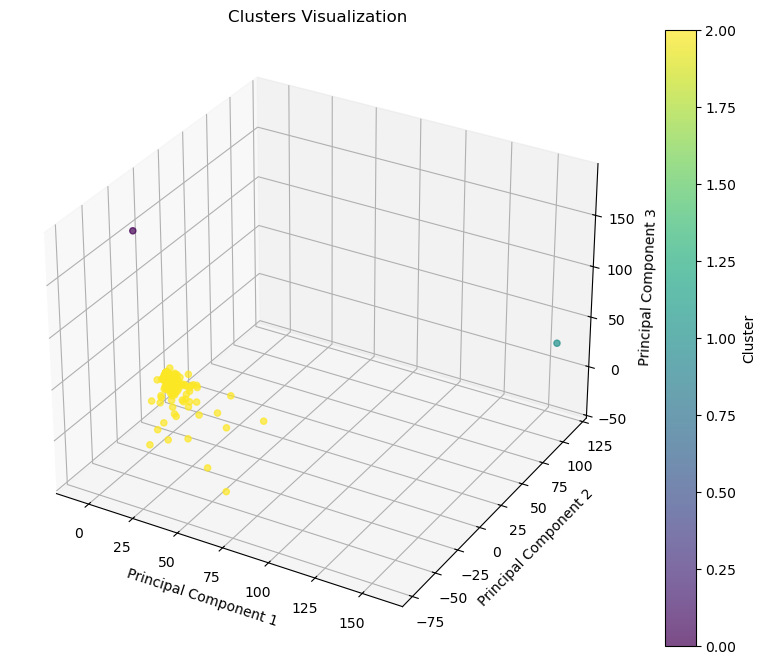

In [12]:
n_clusters = 3
hierarchical_agg = HierarchicalClusterModel(n_clusters=n_clusters, method='agglomerative')
hierarchical_agg.fit(X_pca_hier)

df_hier['cluster_label_hierarchical_agglomerative'] = hierarchical_agg.labels_
logger.info(df_hier["cluster_label_hierarchical_agglomerative"].value_counts())
plot_clusters(X_pca_hier, hierarchical_agg.labels_, dim=3)

In [ ]:
Z = linkage(X_pca_hier, method='ward')

for k in range(2, 15):
    model = HierarchicalClusterModel(k, method='divisive')
    model.fit(Z)
    labels = model.labels_
    score = silhouette_score(Z, labels)
    print(k, score)

Divisive Clustering: 100%|██████████| 2/2 [00:00<00:00, 18.60it/s]
/var/folders/_k/m1mygzyn5n7f9s1mcnb2hgxm0000gn/T/ipykernel_12558/2754924624.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hier['cluster_label_hierarchical_divisive'] = hierarchical_div.labels_
2025-12-01 11:35:06.603 | INFO     | __main__:<module>:6 - cluster_label_hierarchical_divisive
2    327
1      3
0      2
Name: count, dtype: int64


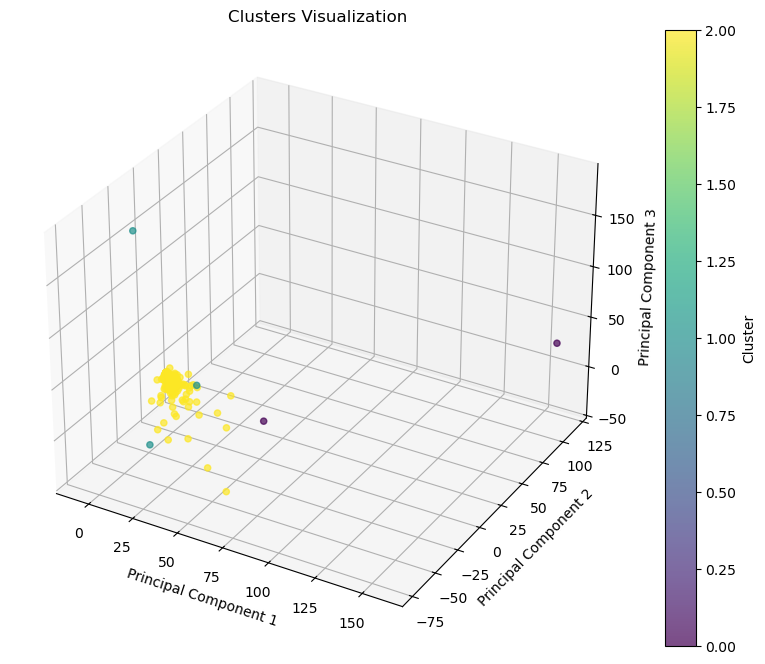

In [13]:
n_clusters = 3
hierarchical_div = HierarchicalClusterModel(n_clusters=n_clusters, method='divisive')
hierarchical_div.fit(X_pca_hier)
df_hier['cluster_label_hierarchical_divisive'] = hierarchical_div.labels_

logger.info(df_hier["cluster_label_hierarchical_divisive"].value_counts())
plot_clusters(X_pca_hier, hierarchical_div.labels_, dim=3)


comparison of clusters

In [18]:
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

data_inputs = ['X_pca', 'X_pca', 'X_hier', 'X_hier']
clustering_methods = ['KMeans', 'DBSCAN', 'Hierarchical (Agg.)', 'Hierarchical (Div.)']

Xs = [X_pca, X_pca, X_hier, X_hier]
labels = [kmeans.labels_, dbscan.labels_, hierarchical_agg.labels_, hierarchical_div.labels_]

results = []

for i in range(len(Xs)):
    X = Xs[i]
    label = labels[i]
    
    if len(set(label)) < 2 or len(set(label)) == len(X):
        print(f"Skipping evaluation for {clustering_methods[i]} on {data_inputs[i]}: Insufficient cluster count or all points are noise/single-point clusters.")
        results.append({
            'Data Input': data_inputs[i],
            'Clustering Method': clustering_methods[i],
            'Silhouette Score': 'N/A',
            'Davies-Bouldin Score': 'N/A',
            'Calinski-Harabasz Score': 'N/A'
        })
        continue

    sil = silhouette_score(X, label)
    db = davies_bouldin_score(X, label)    
    ch = calinski_harabasz_score(X, label)
    
    results.append({
        'Data Input': data_inputs[i],
        'Clustering Method': clustering_methods[i],
        'Silhouette Score': sil,
        'Davies-Bouldin Score': db,
        'Calinski-Harabasz Score': ch
    })

results_df = pd.DataFrame(results)

print("\n Clustering Evaluation Results")
print("-----------------------------------")
print(results_df.to_string(index=False, float_format="%.4f"))


 Clustering Evaluation Results
-----------------------------------
Data Input   Clustering Method  Silhouette Score  Davies-Bouldin Score  Calinski-Harabasz Score
     X_pca              KMeans            0.6662                2.1347                   9.2642
     X_pca              DBSCAN            0.4120               14.1257                  11.5084
    X_hier Hierarchical (Agg.)            0.3902                0.3486                  21.5242
    X_hier Hierarchical (Div.)            0.2993                1.6600                   7.7169
